LGD: The percentage of the exposure that was lost after borrower defaulted. 

EAD: The amount of exposure at the moment the borrower defaulted. 

The feature variables in LGD and EAD models need not to be one-hot encoded variables. 

In [1]:
import re
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from joblib import dump
import statsmodels.api as sm
from logistic_regression_wrapper import LogisticRegressionWrapper
from linear_regression_wrapper import LinearRegressionWrapper
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
data_path = f"./data/"
model_path = f"./models/"

In [3]:
train_data = pd.read_csv(f"{data_path}processed_train.csv")
test_data = pd.read_csv(f"{data_path}processed_test.csv")

data = pd.concat([train_data, test_data], ignore_index=True)
data_copy = data.copy()


In [4]:
loan_defaults = data_copy["loan_status"].isin(["Charged Off", "Does not meet the credit policy. Status:Fully Paid"])
loan_defaults.shape

(466285,)

In [5]:
pd.options.display.max_rows = None

In [6]:
data_copy.isnull().sum().sort_values()

Unnamed: 0                                                              0
purpose:medical_vacation_wedding                                        0
purpose:educ_small_biz_wedd_renno_enerby_moving_other_house             0
addr_state:WV_WY_DC_ME                                                  0
addr_state:VT_MS_NH_AK_MT                                               0
addr_state:IL_SC_CT_KS_CO                                               0
addr_state:IN_OR_WA_WI                                                  0
purpose:major_purchase_home_imp_car                                     0
addr_state:KY_MN_GA_SD                                                  0
addr_state:AR_PR_MI                                                     0
addr_state:NJ_AZ_VA_OK_TN                                               0
addr_state:NC_NM                                                        0
addr_state:LA_MO_DE_MD                                                  0
addr_state:NE_IA_NV_AL_ID_ND_FL_HI    

In [7]:
data_copy["mths_since_last_delinq"].fillna(0, inplace=True)

In [8]:
data_copy["recovery_rate"] = data_copy['recoveries'] / data_copy['funded_amnt']

data_copy["recovery_rate"].describe()

count    466285.000000
mean          0.005640
std           0.032533
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.220774
Name: recovery_rate, dtype: float64

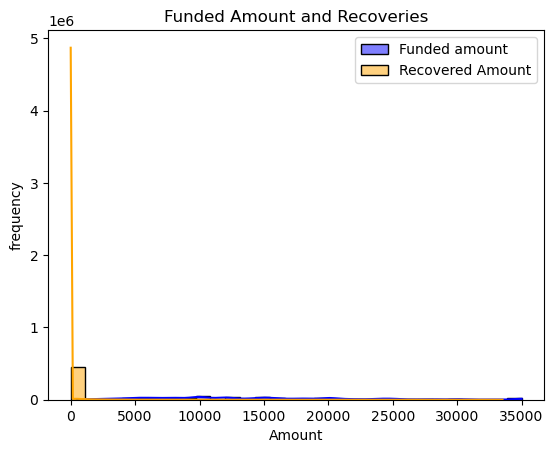

In [9]:
# Create a distribution plot for each distribution

sns.histplot(data=data_copy, x='funded_amnt', bins=30, kde=True, label='Funded amount', color='blue')
sns.histplot(data=data_copy, x='recoveries', bins=30, kde=True, label='Recovered Amount', color='orange')

# sns.kdeplot(suspects["total_rec_prncp"], label='total recovered principle', color='orange')

# Add labels and title
plt.ylabel('frequency')
plt.xlabel('Amount')
plt.title('Funded Amount and Recoveries')

# Add a legend
plt.legend()

# Show the plot
plt.show()

The LGD rate should fall in 0 - 1 range. As displayed by described method, the max value of recovery rate is 1.22 that could be result of accounting error. Lets clipt them to 1.

In [10]:
data_copy["recovery_rate"] = np.where(data_copy["recovery_rate"] > 1, 1, data_copy["recovery_rate"])
data_copy["recovery_rate"] = np.where(data_copy["recovery_rate"] < 0, 0, data_copy["recovery_rate"])
data_copy["recovery_rate"].describe()

count    466285.000000
mean          0.005635
std           0.032380
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: recovery_rate, dtype: float64

EAD = total funded amount X credit conversion factor

Default at a % of the funded amount (credit conversion factor) i.e defaulted at amount 360000 (still need to pay by borrower) / funded amount 

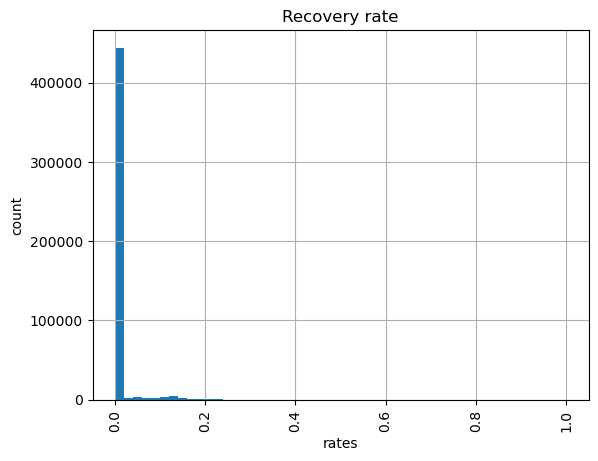

In [11]:
plt.hist(data_copy["recovery_rate"], bins=50)     
plt.title("Recovery rate")
plt.grid(True)
plt.xlabel("rates")
plt.xticks(rotation=90)
plt.ylabel("count")
plt.show()


In [12]:
# total recovered principal is the payments made on the principal of the loan. CCF is credit conversion factor
data_copy["ccf"] = (data_copy['funded_amnt'] - data_copy["total_rec_prncp"]) / data_copy["funded_amnt"]
data_copy["ccf"].describe()

count    466285.000000
mean          0.344844
std           0.327627
min          -0.021734
25%           0.000000
50%           0.347625
75%           0.643997
max           1.000000
Name: ccf, dtype: float64

In [13]:
suspects =  data_copy.loc[data_copy.loc[data_copy["ccf"] < 0].index, ["funded_amnt", "total_rec_prncp"]]
suspects.describe()

,funded_amnt,total_rec_prncp
count,1412.000000,1412.000000
mean,14377.195467,14377.642025
std,7453.893393,7454.698969
min,1000.000000,1000.010000
25%,9000.000000,9000.010000
50%,13000.000000,13000.010000
75%,20000.000000,20000.010000
max,35000.000000,35000.030000


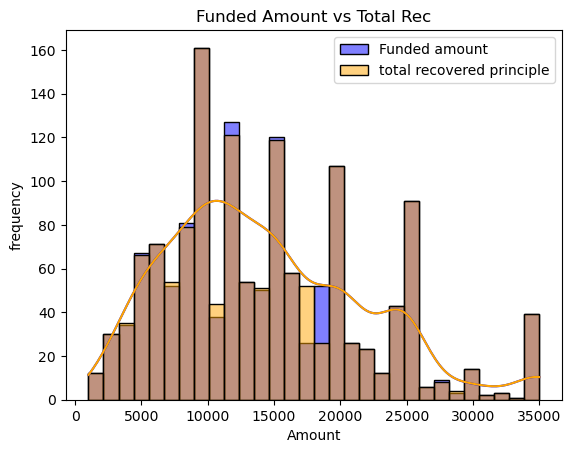

In [14]:
# Create a distribution plot for each distribution

sns.histplot(data=suspects, x='funded_amnt', bins=30, kde=True, label='Funded amount', color='blue')
sns.histplot(data=suspects, x='total_rec_prncp', bins=30, kde=True, label='total recovered principle', color='orange')

# sns.kdeplot(suspects["total_rec_prncp"], label='total recovered principle', color='orange')

# Add labels and title
plt.ylabel('frequency')
plt.xlabel('Amount')
plt.title('Funded Amount vs Total Rec')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [15]:
data_copy["ccf"] = np.where(data_copy["ccf"]  < 0, 0, data_copy["ccf"])

In [16]:
data_copy["ccf"].describe()

count    466285.000000
mean          0.344844
std           0.327627
min           0.000000
25%           0.000000
50%           0.347625
75%           0.643997
max           1.000000
Name: ccf, dtype: float64

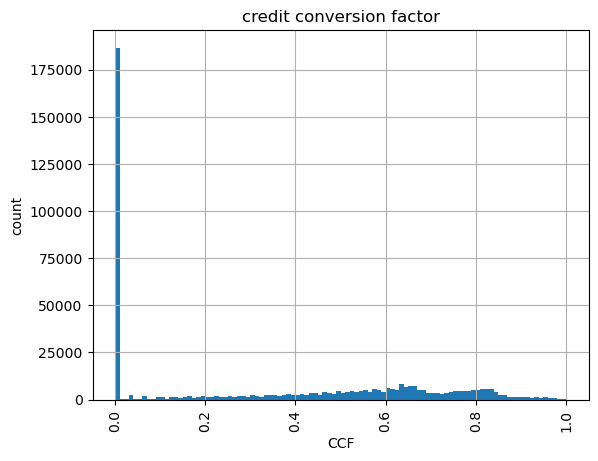

In [17]:
plt.hist(data_copy["ccf"], bins=100)     
plt.title("credit conversion factor")
plt.grid(True)
plt.xlabel("CCF")
plt.xticks(rotation=90)
plt.ylabel("count")
plt.show()


We can use logistic regression at first to predict if the recovery rate is zero or not, and then use linear regression to predicrt precise % of recovery rates, if the rate is not zero.

In [18]:
data_copy["recovery_rate_0_1"] = np.where(data_copy["recovery_rate"] == 0, 0, 1)
data_copy["recovery_rate_0_1"].head()

0    1
1    0
2    0
3    1
4    1
Name: recovery_rate_0_1, dtype: int64

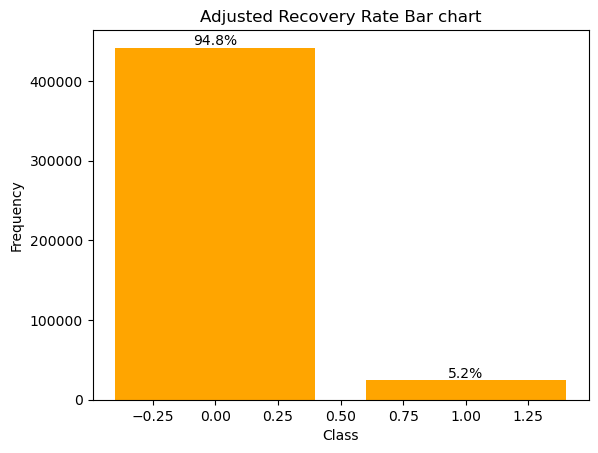

In [19]:
# Calculate percentages
percentages = [(count / data_copy.shape[0]) * 100 for count in data_copy["recovery_rate_0_1"].value_counts()]

# Plot the bar chart
fig, ax = plt.subplots()
bars = ax.bar(data_copy["recovery_rate_0_1"].value_counts().index, data_copy["recovery_rate_0_1"].value_counts(), color='orange')

# Add percentages to the bars
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f}%', ha='center', va='bottom')

plt.title("Adjusted Recovery Rate Bar chart")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()


This will make our learning completley biased towards the negative class.

In [20]:
features_all = [
    'grade:A',
    'grade:B',
    'grade:C',
    'grade:D',
    'grade:E',
    'grade:F',
    'grade:G',
    'home_ownership:MORTGAGE',
    'home_ownership:NONE',
    'home_ownership:OTHER',
    'home_ownership:OWN',
    'home_ownership:RENT',
    'verification_status:Not Verified',
    'verification_status:Source Verified',
    'verification_status:Verified',
    'purpose:car',
    'purpose:credit_card',
    'purpose:debt_consolidation',
    'purpose:educational',
    'purpose:home_improvement',
    'purpose:house',
    'purpose:major_purchase',
    'purpose:medical',
    'purpose:moving',
    'purpose:other',
    'purpose:renewable_energy',
    'purpose:small_business',
    'purpose:vacation',
    'purpose:wedding',
    'initial_list_status:f',
    'initial_list_status:w',
    'term',
    'emp_length',
    'months_since_issued_date',
    'months_since_earliest_cr_line',
    'funded_amnt',
    'int_rate',
    'installment',
    'annual_inc',
    'dti',
    'delinq_2yrs',
    'inq_last_6mths',
    'mths_since_last_delinq',
    'mths_since_last_record',
    'open_acc',
    'pub_rec',
    'total_acc',
    'acc_now_delinq',
    'total_rev_hi_lim'
]

ref_category_list = ["grade:G", "verification_status:Verified", "purpose:credit_card",  "initial_list_status:f"]

In [21]:
x_train, x_test, y_train, y_test = train_test_split(data_copy.drop(["good_bad", "recovery_rate", "recovery_rate_0_1", "ccf"], axis=1), data_copy["recovery_rate_0_1"], test_size=0.2, random_state=45)
print(f"[Train]: x:{x_train.shape}, y:{y_train.shape},  [Test]: x:{x_test.shape}, y: {y_test.shape}")

[Train]: x:(373028, 298), y:(373028,),  [Test]: x:(93257, 298), y: (93257,)


Filtering the input 

In [22]:
filtered_x_train = x_train[features_all]
filtered_x_train = filtered_x_train.drop(ref_category_list, axis=1)

print(f"final train data shape: {filtered_x_train.shape}")

final train data shape: (373028, 45)


In [23]:
filtered_x_test = x_test[features_all]
filtered_x_test = filtered_x_test.drop(ref_category_list, axis=1)

print(f"final test data shape: {filtered_x_test.shape}")

final test data shape: (93257, 45)


In [24]:
filtered_x_train.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'home_ownership:RENT', 'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term', 'emp_length',
       'months_since_issued_date', 'months_since_earliest_cr_line',
       'funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=objec

In [25]:
lgd_model = LogisticRegressionWrapper(solver="liblinear")
lgd_model.fit(filtered_x_train, y_train)
lgd_model.feature_names = filtered_x_train.columns.values

In [26]:
summary = pd.DataFrame(columns=["feature"], data=lgd_model.feature_names)
summary["coefficients"] = np.transpose(lgd_model.coef_)
summary["z_score"] = lgd_model.z_scores
summary['p_value'] = lgd_model.p_values
summary.index = summary.index + 1
summary.loc[0] = ["intercept", lgd_model.intercept_[0], np.nan, np.nan]
summary = summary.sort_index()
summary

,feature,coefficients,z_score,p_value
0,intercept,-0.001046,NaN,NaN
1,grade:A,-0.001150,-0.008742,9.930249e-01
2,grade:B,-0.001314,-0.011439,9.908731e-01
3,grade:C,-0.000453,-0.004362,9.965195e-01
4,grade:D,0.000500,0.005224,9.958322e-01
5,grade:E,0.000677,0.007423,9.940773e-01
6,grade:F,0.000532,0.005697,9.954547e-01
7,home_ownership:MORTGAGE,-0.000444,-0.002196,9.982475e-01
8,home_ownership:NONE,0.000003,0.000004,9.999971e-01
9,home_ownership:OTHER,0.000011,0.000026,9.999796e-01


In [27]:
y_hat_probab = lgd_model.model.predict_proba(filtered_x_test)
y_hat_probab

array([[0.98457752, 0.01542248],
       [0.94626453, 0.05373547],
       [0.94520807, 0.05479193],
       ...,
       [0.9249078 , 0.0750922 ],
       [0.96301957, 0.03698043],
       [0.96883451, 0.03116549]])

In [28]:
y_hat_probab = y_hat_probab[:][:, 1]
y_hat_probab

array([0.01542248, 0.05373547, 0.05479193, ..., 0.0750922 , 0.03698043,
       0.03116549])

In [29]:
temp_df = y_test.reset_index(drop=True)
actual_vs_predicted = pd.concat([temp_df, pd.DataFrame(y_hat_probab)], axis=1)
actual_vs_predicted.columns = ["test_acual", "test_probab"]
actual_vs_predicted.index = y_test.index
actual_vs_predicted.head()                             

,test_acual,test_probab
47140,0,0.015422
307584,0,0.053735
209316,0,0.054792
116227,0,0.050156
272299,0,0.059893


In [30]:
tr = 0.5
actual_vs_predicted["y_hat"] = np.where(actual_vs_predicted["test_probab"] > tr, 1, 0)
cm = confusion_matrix(actual_vs_predicted["test_acual"], actual_vs_predicted["y_hat"])
cm


array([[88327,     0],
       [ 4930,     0]])

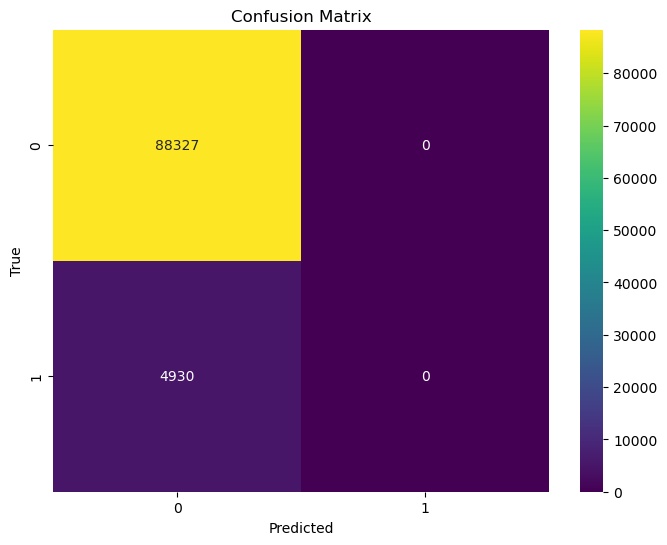

In [31]:
# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

The result is bizzare !! 

Lets create a model with balanced class training. We can use a following methods:
- class weighting 
- Resampling techniques 
- Ensemble Methods 
- Cost sensitve function 


For a quick experiment, we will use class weighting method, and examine the result

In [32]:
balanced_lgd_model = LogisticRegressionWrapper(solver="liblinear", class_weight ="balanced")
balanced_lgd_model.fit(filtered_x_train, y_train)
balanced_lgd_model.feature_names = filtered_x_train.columns.values

In [33]:
balanced_y_hat = balanced_lgd_model.model.predict(filtered_x_test)

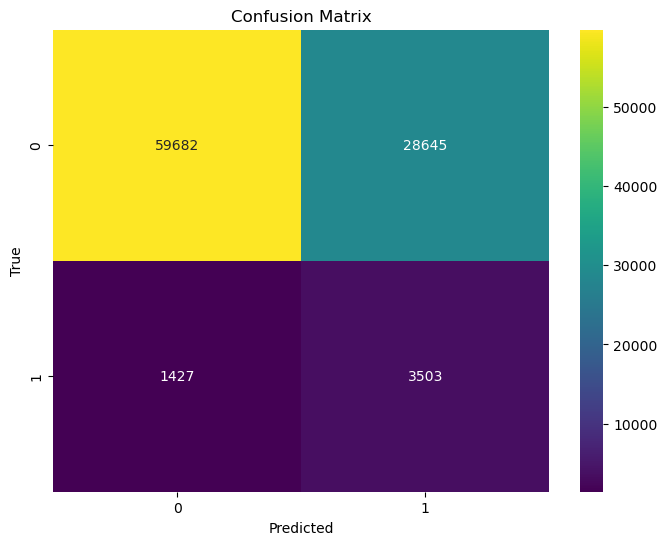

In [34]:
cm = confusion_matrix(y_test, balanced_y_hat)
# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [35]:
clf_report = classification_report(y_test, balanced_y_hat)
print(clf_report)

              precision    recall  f1-score   support

           0       0.98      0.68      0.80     88327
           1       0.11      0.71      0.19      4930

    accuracy                           0.68     93257
   macro avg       0.54      0.69      0.49     93257
weighted avg       0.93      0.68      0.77     93257



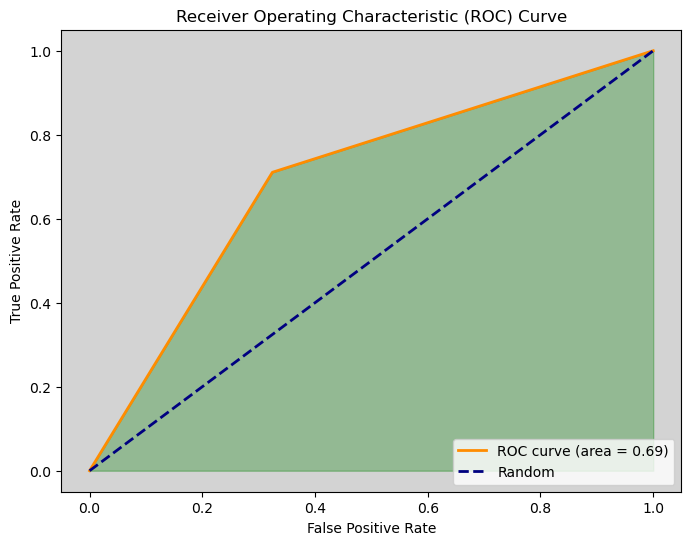

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, balanced_y_hat)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 6))

# Set background color and alpha (transparency)
ax.set_facecolor('lightgray')  # You can change 'lightgray' to any color you want
ax.set_alpha(0.3)  # Adjust alpha for transparency


ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
ax.fill_between(fpr, 0, tpr, color='green', alpha=0.3)
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc='lower right')
plt.show()

In [37]:
# saving the model => we can agree on this model's performance. We will build btter model in _one.
dump(balanced_lgd_model, f"{model_path}balanced_lgd_zero.joblib")

['./models/balanced_lgd_zero.joblib']

#### Linear Regression 
This will predict the recovery rate which is not equal to zero.

In [38]:
lr_data_copy = data_copy[data_copy["recovery_rate_0_1"] == 1]
lr_data_copy.shape

(24371, 302)

In [39]:
x_train_lr, x_test_lr, y_train_lr, y_test_lr = train_test_split(lr_data_copy.drop(["good_bad", "recovery_rate", "recovery_rate_0_1", "ccf"], axis=1), lr_data_copy["recovery_rate"], test_size=0.2, random_state=45)
print(f"[Train]: x:{x_train_lr.shape}, y:{y_train_lr.shape},  [Test]: x:{x_test_lr.shape}, y: {y_test_lr.shape}")

[Train]: x:(19496, 298), y:(19496,),  [Test]: x:(4875, 298), y: (4875,)


In [40]:
filtered_x_train_lr = x_train_lr[features_all]
filtered_x_train_lr = filtered_x_train_lr.drop(ref_category_list, axis=1)


filtered_x_test_lr = x_test_lr[features_all]
filtered_x_test_lr = filtered_x_test_lr.drop(ref_category_list, axis=1)

print(f"final train data shape: {filtered_x_train_lr.shape}")

final train data shape: (19496, 45)


In [41]:
lgd_lr_model = LinearRegressionWrapper()
lgd_lr_model.fit(filtered_x_train_lr, y_train_lr)

LinearRegressionWrapper()

Evaluation

In [42]:
y_hat_lr = lgd_lr_model.predict(filtered_x_test_lr)

In [43]:
mae = mean_absolute_error(y_test_lr, y_hat_lr)
print(f"MAE: {mae}")

MAE: 0.04457435827501758


<Figure size 800x600 with 0 Axes>

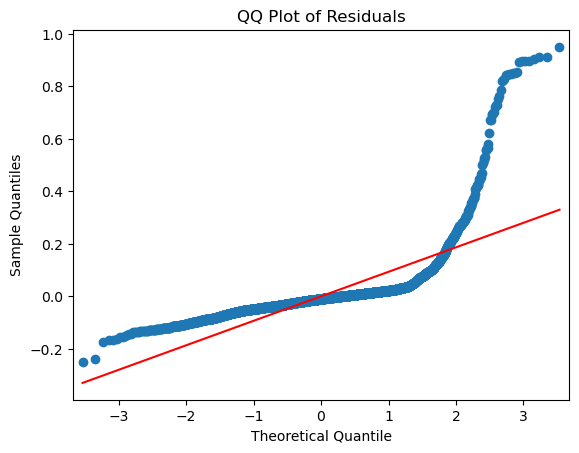

In [44]:
plt.figure(figsize=(8, 6))
sm.qqplot(y_test_lr - y_hat_lr, line='s')
# Set plot labels and title
plt.title('QQ Plot of Residuals')
plt.xlabel('Theoretical Quantile')
# Show the plot
plt.show()

This moodle is not performing good, we will develope  btter model.

In [45]:
lgd_lr_model.feature_names = filtered_x_train_lr.columns.values

In [46]:
summary = pd.DataFrame(columns=["feature"], data=lgd_lr_model.feature_names)
summary["coefficients"] = np.transpose(lgd_lr_model.coef_)
summary['p_value'] = lgd_lr_model.p.round(4)
summary.index = summary.index + 1
summary.loc[0] = ["intercept", lgd_lr_model.intercept_, np.nan]
summary = summary.sort_index()
summary

,feature,coefficients,p_value
0,intercept,4.032236e-01,NaN
1,grade:A,-6.762540e-02,0.0000
2,grade:B,-5.418444e-02,0.0000
3,grade:C,-4.147102e-02,0.0000
4,grade:D,-3.141012e-02,0.0000
5,grade:E,-1.850318e-02,0.0004
6,grade:F,-6.380345e-03,0.2152
7,home_ownership:MORTGAGE,-4.451539e-02,0.0165
8,home_ownership:NONE,1.396519e-01,0.0017
9,home_ownership:OTHER,-6.514103e-03,0.8001


Les build another linear regression model for the EAD estimation.

In [47]:
x_train_ead, x_test_ead, y_train_ead, y_test_ead = train_test_split(lr_data_copy.drop(["good_bad", "recovery_rate", "recovery_rate_0_1", "ccf"], axis=1), lr_data_copy["ccf"], test_size=0.2, random_state=45)
print(f"[Train]: x:{x_train_ead.shape}, y:{y_train_ead.shape},  [Test]: x:{x_test_ead.shape}, y: {y_test_ead.shape}")

[Train]: x:(19496, 298), y:(19496,),  [Test]: x:(4875, 298), y: (4875,)


In [48]:
filtered_x_train_ead = x_train_ead[features_all]
filtered_x_train_ead = filtered_x_train_ead.drop(ref_category_list, axis=1)


filtered_x_test_ead = x_test_ead[features_all]
filtered_x_test_ead = filtered_x_test_ead.drop(ref_category_list, axis=1)

print(f"final train data shape: {filtered_x_train_ead.shape}")

final train data shape: (19496, 45)


In [49]:
ead_model = LinearRegressionWrapper()
ead_model.fit(filtered_x_train_ead, y_train_ead)
ead_model.feature_names = filtered_x_train_ead.columns.values

In [50]:
y_hat_ead = ead_model.predict(filtered_x_test_ead)
mae = mean_absolute_error(y_test_ead, y_hat_ead)
print(f"MAE: {mae}")

MAE: 0.12970958890417


<Figure size 800x600 with 0 Axes>

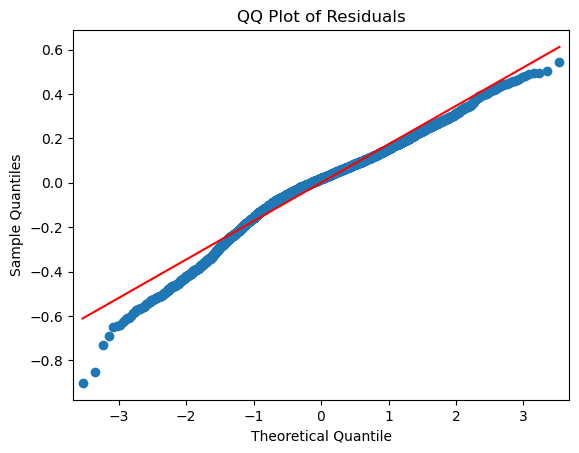

In [51]:
residuals = y_test_ead - y_hat_ead

plt.figure(figsize=(8, 6))
sm.qqplot(residuals, line='s')
# Set plot labels and title
plt.title('QQ Plot of Residuals')
plt.xlabel('Theoretical Quantile')
# Show the plot
plt.show()

In [52]:
summary.feature.describe()

count            46
unique           46
top       intercept
freq              1
Name: feature, dtype: object

In [53]:
summary = pd.DataFrame(columns=["feature"], data=ead_model.feature_names)
summary["coefficients"] = np.transpose(ead_model.coef_)
summary['p_value'] = ead_model.p.round(4)
summary.index = summary.index + 1
summary.loc[0] = ["intercept", ead_model.intercept_, np.nan]
summary = summary.sort_index()
summary

,feature,coefficients,p_value
0,intercept,1.564457e+00,NaN
1,grade:A,-2.521382e-01,0.0000
2,grade:B,-1.927740e-01,0.0000
3,grade:C,-1.387701e-01,0.0000
4,grade:D,-9.413940e-02,0.0000
5,grade:E,-5.564444e-02,0.0000
6,grade:F,-1.865010e-02,0.0589
7,home_ownership:MORTGAGE,-2.466594e-02,0.4886
8,home_ownership:NONE,6.846095e-02,0.4226
9,home_ownership:OTHER,-1.843127e-02,0.7087


In [54]:
pd.DataFrame(y_hat_ead).describe()

,0
count,4875.000000
mean,0.735378
std,0.116270
min,0.350637
25%,0.656702
50%,0.736161
75%,0.818138
max,1.062135


In [55]:
dump(ead_model, f"{model_path}ead_zero.joblib")

['./models/ead_zero.joblib']